In [25]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
from fastfm2 import als

In [26]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [4]:
data_dir = "C:/Users/samsung/UCSD/Fall22/CSE258/archive"
df_recipes = pd.read_csv(f"{data_dir}/RAW_recipes.csv")
print(df_recipes.shape)
print(df_recipes.columns)

(231637, 12)
Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')


In [27]:
df_interactions = pd.read_csv(f"{data_dir}/RAW_interactions.csv")
print(df_interactions.shape)
print(len(df_interactions))
print(df_interactions.columns)

(1132367, 5)
1132367
Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')


In [28]:
userIDs, itemIDs = {}, {}

for i in range(len(df_interactions)):
    d = df_interactions.iloc[i]
    u,i = d['user_id'], d['recipe_id']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers, nItems = len(userIDs), len(itemIDs)
print(nUsers)
print(nItems)

226570
231637


In [29]:
X = scipy.sparse.lil_matrix((len(df_interactions), nUsers+nItems))
print(len(df_interactions))
print(nUsers+nItems)
print(X.shape)

1132367
458207
(1132367, 458207)


In [30]:
y = []
for i in range(len(df_interactions)):
    d = df_interactions.iloc[i]
    user = userIDs[d['user_id']]
    item = itemIDs[d['recipe_id']]
    X[i,user] = 1
    X[i,nUsers+item] = 1
    y.append(d['rating'])
y = np.array(y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=None, random_state=6752)

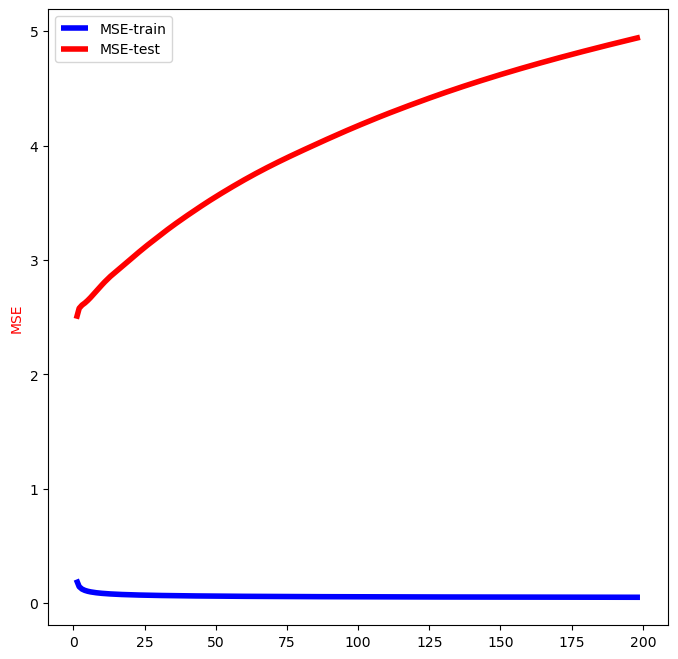

In [35]:
fm = als.FMRegression(n_iter=0, init_stdev=0.1, rank=5, l2_reg_w=0.01, l2_reg_V=0.01)

n_iter = 200
step_size = 1
rmse_train = []
rmse_test = []

for i in range(1, n_iter):
    fm.fit(X_train, y_train, n_more_iter=step_size)
    y_pred = fm.predict(X_test)

    rmse_train.append(MSE(fm.predict(X_train), y_train))
    rmse_test.append(MSE(fm.predict(X_test), y_test))

from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=1, figsize=(8, 8))

x = np.arange(1, n_iter) * step_size
with plt.style.context('fivethirtyeight'):
    axes.plot(x, rmse_train, label='MSE-train', color='b')
    axes.plot(x, rmse_test, label='MSE-test', color='r')
axes.set_ylabel('MSE', color='r')
axes.legend()

In [9]:
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=5, l2_reg_w=0.5, l2_reg_V=0.5)
fm.fit(X_train, y_train)

In [11]:
y_pred_with_features = fm.predict(X_test)
MSE(y_pred_with_features, y_test)

2.1214886211439374

In [7]:
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
for i in range(len(df_interactions)):
    r = df_interactions.iloc[i]
    reviewsPerUser[r['user_id']].append(r)
    reviewsPerItem[r['recipe_id']].append(r)

In [8]:
# FISM
X = scipy.sparse.lil_matrix((len(df_interactions), nItems+nItems))

y = []
for i in range(len(df_interactions)):
    d = df_interactions.iloc[i]
    user = userIDs[d['user_id']]
    item = itemIDs[d['recipe_id']]
    X[i,item] = 1
    for r in reviewsPerUser[user]:
        item_hist = itemIDs[r['recipe_id']]
        if item_hist == item:
            continue
        X[i,nItems+item_hist] = 1
    y.append(d['rating'])
y = np.array(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=None, random_state=6752)
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=5, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X_train, y_train)

FMRegression(l2_reg_V=0.5, n_iter=1000, rank=5)

In [10]:
y_pred_with_features = fm.predict(X_test)
MSE(y_pred_with_features, y_test)

2.219829801489125

In [11]:
data = pd.merge(df_recipes, df_interactions, right_on='recipe_id',left_on='id')
print(data.shape)
data.head(3)

(1132367, 17)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...


In [12]:
data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = data.nutrition.str.split(",",expand=True) 
data['calories'] = data['calories'].apply(lambda x: x.replace("[" ,""))
data['carbohydrates'] = data['carbohydrates'].apply(lambda x: x.replace("]" ,""))
data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] =  data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']].astype(float)

In [15]:
# add time components(nsteps, minutes)
X = scipy.sparse.lil_matrix((len(df_interactions), nUsers+nItems+1))

y = []
for i in range(len(data)):
    d = data.iloc[i]
    user = userIDs[d['user_id']]
    item = itemIDs[d['recipe_id']]
    X[i,user] = 1
    X[i,nUsers+item] = 1
    X[i,-1] = d['n_steps']
    y.append(d['rating'])
y = np.array(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=None, random_state=6752)
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=5, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X_train, y_train)

FMRegression(l2_reg_V=0.5, n_iter=1000, rank=5)

In [17]:
y_pred_with_features = fm.predict(X_test)
MSE(y_pred_with_features, y_test)

2.4765802319812993

In [18]:
fm = als.FMRegression(n_iter=100, init_stdev=0.1, rank=5, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X_train, y_train)

FMRegression(l2_reg_V=0.5, rank=5)

In [19]:
y_pred_with_features = fm.predict(X_test)
MSE(y_pred_with_features, y_test)

2.2059832171437574

In [24]:
fm = als.FMRegression(n_iter=0, init_stdev=0.1, rank=5, l2_reg_w=0.5, l2_reg_V=0.5)

n_iter = 1000
step_size = 1
rmse_train = []
rmse_test = []

for i in range(1, n_iter):
    fm.fit(X_train, y_train, n_more_iter=step_size)
    y_pred = fm.predict(X_test)

    rmse_train.append(MSE(fm.predict(X_train), y_train))
    rmse_test.append(MSE(fm.predict(X_test), y_test))

KeyboardInterrupt: 

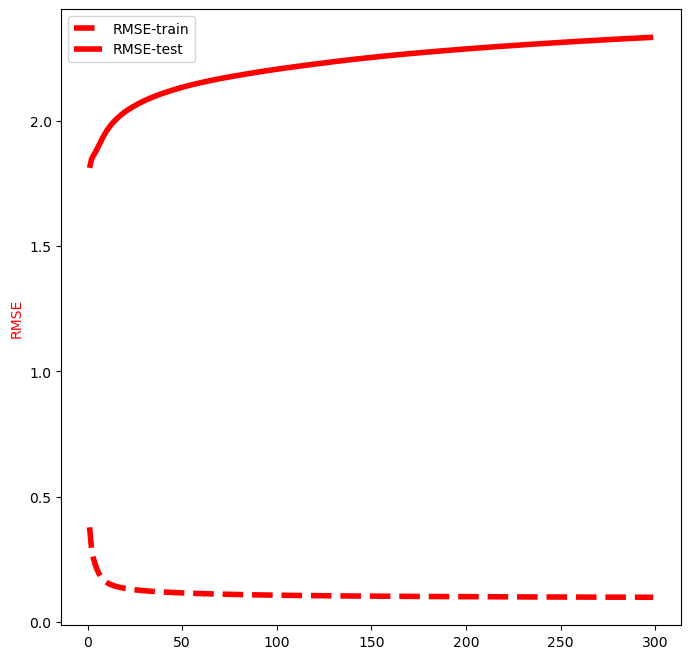

In [23]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=1, figsize=(8, 8))

x = np.arange(1, n_iter) * step_size
with plt.style.context('fivethirtyeight'):
    axes.plot(x, rmse_train, label='RMSE-train', color='r', ls="--")
    axes.plot(x, rmse_test, label='RMSE-test', color='r')
axes.set_ylabel('RMSE', color='r')
axes.legend()